### Final Code for Sex differences project 

### 1. Prep data set 

In [90]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy.stats import zscore, norm, pearsonr
import matplotlib.pyplot as plt 

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from pathlib import Path

from nltools.stats import fdr

from sklearn.metrics import confusion_matrix


In [3]:
#import data set
df = pd.read_csv("/home/xlajoie/Desktop/unrestricted_original.csv")

In [4]:
# Filter left-handers (>=50 handedness) 
df = df[df["Handedness"] >= 50].reset_index()


In [5]:
# transform M and F with 0 and 1 
df.rename(columns={"Subject": "subject_label"}, inplace=True)
df["Gender"] = df["Gender"].replace({"M": 0, "F": 1})
df

,index,subject_label,Release,Acquisition,Gender,Age_in_Yrs,Race,Ethnicity,Handedness,Education,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,S900,Q11,0,27,White,Not Hispanic/Latino,65,16.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,S900,Q08,0,27,White,Not Hispanic/Latino,85,16.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,S500,Q06,1,35,Black or African Am.,Not Hispanic/Latino,90,12.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,S500,Q06,0,24,White,Hispanic/Latino,80,12.0,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,S900,Q10,0,30,White,Not Hispanic/Latino,50,14.0,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,662,990366,S900,Q10,0,22,White,Not Hispanic/Latino,95,15.0,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
560,663,991267,S500,Q06,0,30,White,Not Hispanic/Latino,75,14.0,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
561,664,992673,S900,Q12,1,33,White,Not Hispanic/Latino,70,14.0,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
562,665,993675,S900,Q09,1,29,White,Not Hispanic/Latino,85,16.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [6]:
print("hommes = ", df['Gender'].value_counts()[0])
print("femmes = ", df['Gender'].value_counts()[1])

hommes =  263
femmes =  301


In [7]:
#save new csv with modifications as "final hcp database"
df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [8]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [9]:
df["Gender"]  # should have the whole list

0      0
1      0
2      1
3      0
4      0
      ..
559    0
560    0
561    1
562    1
563    1
Name: Gender, Length: 564, dtype: int64

# Atlas Destrieux

#### Bootstrapping

In [70]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1)
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [126]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    #z_scores = np.mean((boot_coefs - np.mean(boot_coefs, axis=0))/np.std(boot_coefs, axis=0), axis=0)
    z_scores = zscore(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [11]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [49]:
df_bootstrap = pd.DataFrame()
bootstrap_coef = []

for i in range(0, 4):
    for j in range(0, 200):
    # for j in range(0, len(df_boot)):
        index = random.randint(0, 200-1)
        # index = random.randint(0, len(df_boot)-1)
        frames = [df_bootstrap, df_boot[index:index+1]]
        df_bootstrap = pd.concat(frames)

    df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)
    
    
    # print(df_bootstrap["Gender"])  # should have the whole list
    
    atlas_dest = datasets.fetch_atlas_destrieux_2009()
    masker = NiftiLabelsMasker(atlas_dest.maps)
    
    
    img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results/sub-{0}/sub-{0}_voxelcorrelations.nii.gz"  # à changer
    x_correl = []
    # nb_subjects = len(df_bootstrap)
    nb_subjects = 200
    subject_label = df_bootstrap["subject_label"][:nb_subjects]

    
    for sub in tqdm(subject_label):
        img_path = str(Path(img_tpl.format(sub)))  # format = remplace entre accolades par # sujet
        x_correl.append(img4d2vector(img_path, masker))

    x_correl = np.array(x_correl)
    x_correl.shape  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds)) 
    
    
    y_sex = df_bootstrap["Gender"][:nb_subjects]  # maybe list(df["Gender"]) 
    
    print(sum(y_sex), len(y_sex))  #double check 
    
    
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data

    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x_correl,  # x 
                                                        y_sex,       # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    #score = cross_val_score(model, X_train, y_train, cv=10)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    
    coef = model.coef_[0]
    bootstrap_coef.append(coef)
    
    df_bootstrap = pd.DataFrame()
    score = []

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 200/200 [01:31<00:00,  2.19it/s]

113 200
train: 160 test: 40


[0.825]


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


predicted class  Femme  Homme
actual class                 
Femme               19      4
Homme                3     14
accuracy test (r2) = 0.825
accuracy train (r2) = 1.0


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 200/200 [01:28<00:00,  2.25it/s]


109 200
train: 160 test: 40
[0.825]


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


predicted class  Femme  Homme
actual class                 
Femme               21      1
Homme                3     15
accuracy test (r2) = 0.9
accuracy train (r2) = 1.0


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 200/200 [01:29<00:00,  2.24it/s]


112 200
train: 160 test: 40
[0.8625]


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


predicted class  Femme  Homme
actual class                 
Femme               20      2
Homme                3     15
accuracy test (r2) = 0.875
accuracy train (r2) = 1.0


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 200/200 [01:34<00:00,  2.11it/s]


106 200
train: 160 test: 40
[0.89375]
predicted class  Femme  Homme
actual class                 
Femme               17      4
Homme                2     17
accuracy test (r2) = 0.85
accuracy train (r2) = 1.0


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of

In [23]:
bootstrap_coef

[array([ 0.03408165, -0.00912286,  0.03858059, ...,  0.00709968,
        -0.00127551,  0.06446551]),
 array([ 0.02911535, -0.03383303,  0.00748557, ..., -0.0131371 ,
        -0.006405  ,  0.01022377]),
 array([-3.55692312e-02,  1.10159022e-02,  1.29660723e-05, ...,
         3.39633907e-02,  1.26279878e-02,  6.23140588e-02]),
 array([ 0.03162599, -0.01556529,  0.04099899, ..., -0.00112342,
         0.00084921,  0.02421687])]

In [47]:
bootstrap_coef

(4, 1184)

In [48]:
atlas_dest["labels"]

rec.array([(  0, 'Background'), (  1, 'L G_and_S_frontomargin'),
           (  2, 'L G_and_S_occipital_inf'),
           (  3, 'L G_and_S_paracentral'), (  4, 'L G_and_S_subcentral'),
           (  5, 'L G_and_S_transv_frontopol'),
           (  6, 'L G_and_S_cingul-Ant'),
           (  7, 'L G_and_S_cingul-Mid-Ant'),
           (  8, 'L G_and_S_cingul-Mid-Post'),
           (  9, 'L G_cingul-Post-dorsal'),
           ( 10, 'L G_cingul-Post-ventral'), ( 11, 'L G_cuneus'),
           ( 12, 'L G_front_inf-Opercular'),
           ( 13, 'L G_front_inf-Orbital'),
           ( 14, 'L G_front_inf-Triangul'), ( 15, 'L G_front_middle'),
           ( 16, 'L G_front_sup'), ( 17, 'L G_Ins_lg_and_S_cent_ins'),
           ( 18, 'L G_insular_short'), ( 19, 'L G_occipital_middle'),
           ( 20, 'L G_occipital_sup'), ( 21, 'L G_oc-temp_lat-fusifor'),
           ( 22, 'L G_oc-temp_med-Lingual'),
           ( 23, 'L G_oc-temp_med-Parahip'), ( 24, 'L G_orbital'),
           ( 25, 'L G_pariet_inf-Angul

In [99]:
z_score, pval, pval_bonf, boot_z_fdr = bootstrap_scores(bootstrap_coef)

NameError: name 'bootstrap_coef' is not defined

In [20]:
coef_image = vector2img4d(boot_z_fdr,masker)

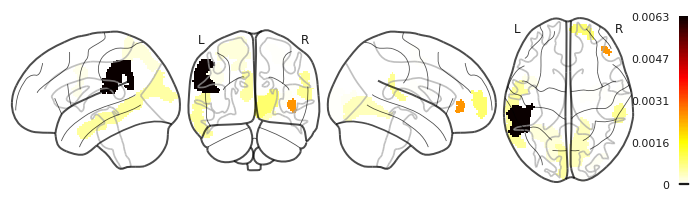

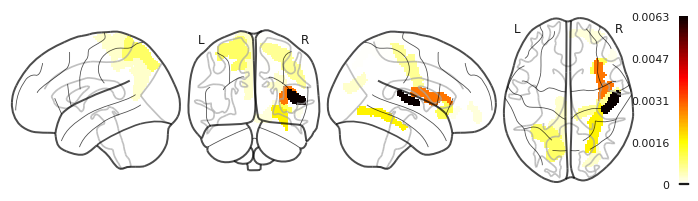

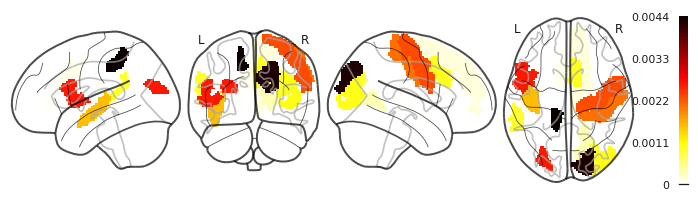

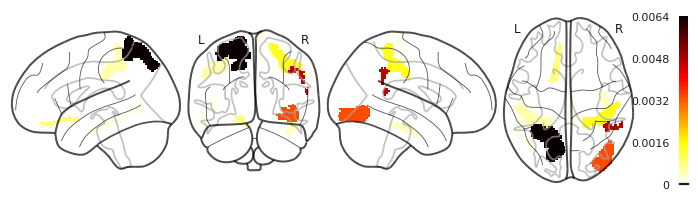

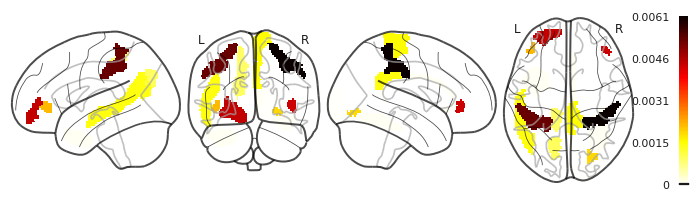

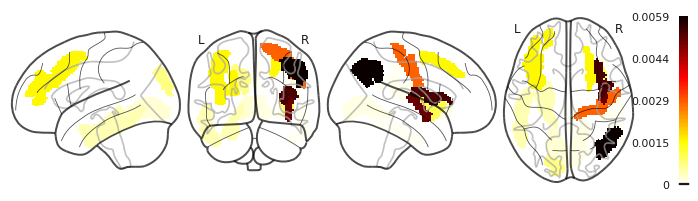

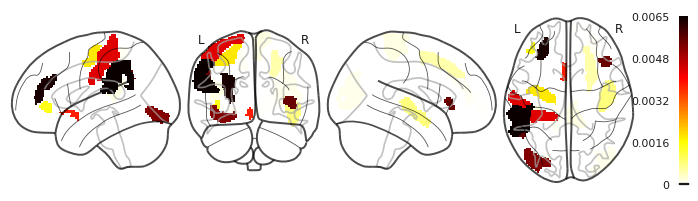

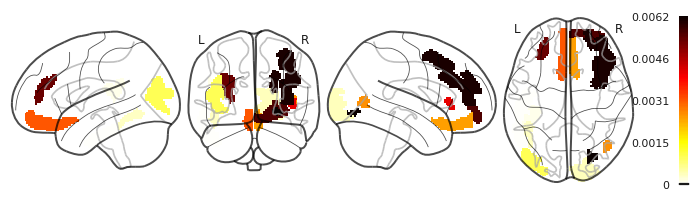

In [21]:
for img in image.iter_img(coef_image):
    # img is now an in-memory 3D img
    plotting.plot_glass_brain(img,display_mode = "lyrz", colorbar=True)

# Bootstrap results

In [11]:
import joblib
import numpy as np
from pathlib import Path


study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path = study_dir / "results" / "models_iteration-10000.pkl"

results = joblib.load(results_path)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)
print(coefs.shape)



(10000, 1184)


In [18]:
data = pd.DataFrame.from_dict(results)

In [20]:
data

,len_X_train,len_X_test,score,confusion_matrix,acc_test,acc_train,model
0,451,113,[0.88024154589372],predicted class Femme Homme actual class ...,0.902655,1.0,LinearSVC(max_iter=10000)
1,451,113,[0.8669565217391304],predicted class Femme Homme actual class ...,0.867257,1.0,LinearSVC(max_iter=10000)
2,451,113,[0.8780676328502416],predicted class Femme Homme actual class ...,0.929204,1.0,LinearSVC(max_iter=10000)
3,451,113,[0.8714492753623186],predicted class Femme Homme actual class ...,0.840708,1.0,LinearSVC(max_iter=10000)
4,451,113,[0.8603381642512076],predicted class Femme Homme actual class ...,0.946903,1.0,LinearSVC(max_iter=10000)
...,...,...,...,...,...,...,...
9995,451,113,[0.8582125603864734],predicted class Femme Homme actual class ...,0.911504,1.0,LinearSVC(max_iter=10000)
9996,451,113,[0.8780676328502415],predicted class Femme Homme actual class ...,0.876106,1.0,LinearSVC(max_iter=10000)
9997,451,113,[0.8580193236714976],predicted class Femme Homme actual class ...,0.893805,1.0,LinearSVC(max_iter=10000)
9998,451,113,[0.8759420289855072],predicted class Femme Homme actual class ...,0.840708,1.0,LinearSVC(max_iter=10000)


In [127]:
moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)

In [81]:
from collections import Counter
Counter(fdr_val)

Counter({0.0: 1184})

In [58]:
fdr_val = fdr_val.reshape(148, 8)

In [62]:
data_fdr = pd.DataFrame(fdr_val, columns=["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])
data_fdr

,opIFG_L,planumtemp_L,aMTG_L,pITG_L,opIFG_R,planumtemp_R,aMTG_R,pITG_R
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
masker.fit()
coef_image = vector2img4d(np.mean(scoresZ, axis=0),masker)

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [158]:
max(np.mean(scoresZ, axis=0))

1.5104606454485746e-14

In [162]:
np.mean(coefs, axis=0)

array([-0.01287422,  0.00377641,  0.03502315, ...,  0.00778186,
       -0.02772408,  0.01919315])

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:373: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


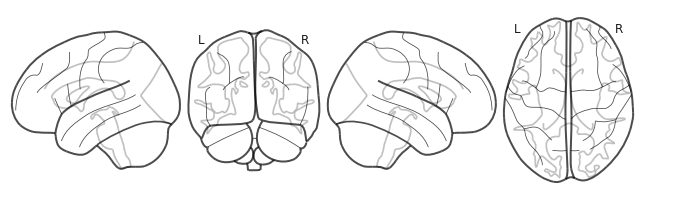

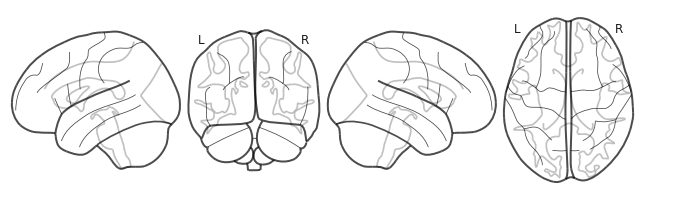

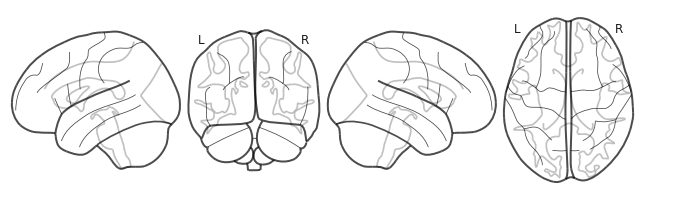

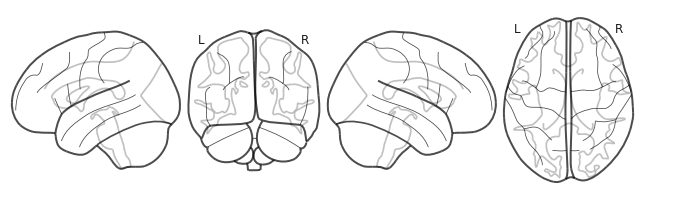

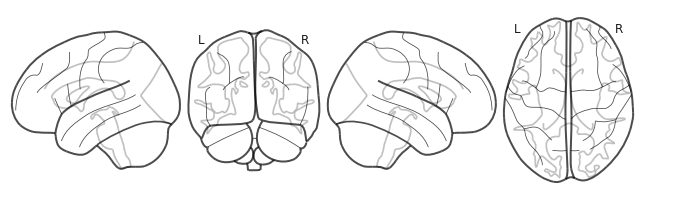

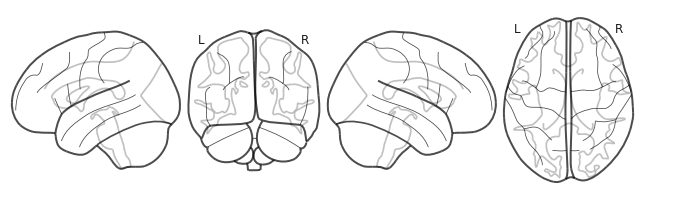

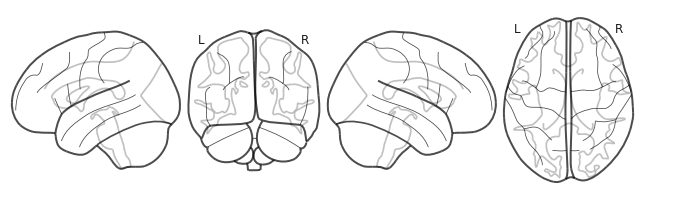

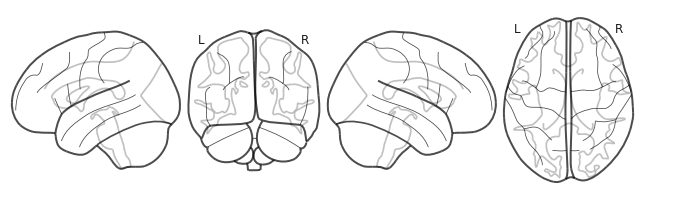

In [137]:
for img in image.iter_img(coef_image):
    # img is now an in-memory 3D img
    plotting.plot_glass_brain(img,display_mode = "lyrz", vmin = min(np.mean(scoresZ, axis=0)), vmax = max(np.mean(scoresZ, axis=0)), colorbar=True, symmetric_cbar = "True")

In [153]:
acc_test = np.asarray(data["acc_test"])
moy = np.mean(acc_test)
se = np.std(acc_test)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print(moy)
print(se)
print(lower)
print(upper)

0.8756353982300885
0.032657349067499834
0.8116269940577888
0.9396438024023882
